# Predicting differences between local and benchmark decisions: Identifying patients that low thrombolsying units would not give thrombolysis to whereas the majority of benchmark hospitals would

## Plain English summary 

In this experiment we compare decisions between the top and bottom 30 hospitals (as ranked by the predicted thrombolysis use in the same 10k cohort of patients). We take those patients that would be given thrombolysis by the majority of the top 30 thombolysing hospitals (we also call these 'benchmark' hospitals), and predict when the bottom 30 hospitals would make a different decision (i.e. decide *not* to thrombolyse).

This notebook uses a separate model per hospital. This experiment is repeated in another notebook which uses a single model for all of the hospitals, for comparison.

We find that low thrombolysing hospitals are less likely to give thrombolysis to patients with:
* Low or very high stroke severity
* An estimated (not precise) stroke onset time
* Prior disability
* A longer arrival-to-scan time
* A longer inset-to-arrival time
* Use of of AF anticoagulants

## Model and data
A XGBoost model is fitted to each of the hosptials to predict whether a patient (which gets thrombolysis from the benchmark majority vote) would *not* get thrombolysis from the bottom 30 hospitals. It uses these 8 features:

* Arrival-to-scan time
* Infarction
* Stroke severity
* Precise onset time
* Prior disability level
* Stroke team
* Use of AF anticoagulants
* Onset-to-arrival time

Results are collected and represented as though the individual hospital models form a single model.

## Aims

* Of all those patients thrombolysed by benchmark decision, build an XGBoost model to predict which patients, would be *not* be thrombolysed at a local unit.
* Investigate model predictions using Shap.

## Observations

* We can predict those that will *not* receive thrombolysis at a local unit, out of those who will be thrombolysed by the majority of the benchmark hospitals, with 67% accuracy (AUC 0.733).

* The five most important distinguishing features are:
    * Stroke severity
    * Prior disability level
    * Precise onset time
    * Arrival-to-scan time
    * Onset-to-arrival time

## A note on Shap values

Shap values are usually reported as *log odds shifts* in model predictions. For a description of the relationships between probability, odds, and Shap values (log odds shifts) see [here](../introduction/odds_prob.md).

## Import libraries

In [1]:
# Turn warnings off to keep notebook tidy
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import auc
from sklearn.metrics import roc_curve

from xgboost import XGBClassifier

import json
import shap

import copy

## Function to calculate accuracy measures

In [2]:
def calculate_accuracy(observed, predicted):
    
    """
    Calculates a range of accuracy scores from observed and predicted classes.
    
    Takes two list or NumPy arrays (observed class values, and predicted class 
    values), and returns a dictionary of results.
    
     1) observed positive rate: proportion of observed cases that are +ve
     2) Predicted positive rate: proportion of predicted cases that are +ve
     3) observed negative rate: proportion of observed cases that are -ve
     4) Predicted negative rate: proportion of predicted cases that are -ve  
     5) accuracy: proportion of predicted results that are correct    
     6) precision: proportion of predicted +ve that are correct
     7) recall: proportion of true +ve correctly identified
     8) f1: harmonic mean of precision and recall
     9) sensitivity: Same as recall
    10) specificity: Proportion of true -ve identified:        
    11) positive likelihood: increased probability of true +ve if test +ve
    12) negative likelihood: reduced probability of true +ve if test -ve
    13) false positive rate: proportion of false +ves in true -ve patients
    14) false negative rate: proportion of false -ves in true +ve patients
    15) true positive rate: Same as recall
    16) true negative rate: Same as specificity
    17) positive predictive value: chance of true +ve if test +ve
    18) negative predictive value: chance of true -ve if test -ve
    
    """
    
    # Converts list to NumPy arrays
    if type(observed) == list:
        observed = np.array(observed)
    if type(predicted) == list:
        predicted = np.array(predicted)
    
    # Calculate accuracy scores
    observed_positives = observed == 1
    observed_negatives = observed == 0
    predicted_positives = predicted == 1
    predicted_negatives = predicted == 0
    
    true_positives = (predicted_positives == 1) & (observed_positives == 1)
    
    false_positives = (predicted_positives == 1) & (observed_positives == 0)
    
    true_negatives = (predicted_negatives == 1) & (observed_negatives == 1)
    
    false_negatives = (predicted_negatives == 1) & (observed_negatives == 0)
    
    accuracy = np.mean(predicted == observed)
    
    precision = (np.sum(true_positives) /
                 (np.sum(true_positives) + np.sum(false_positives)))
        
    recall = np.sum(true_positives) / np.sum(observed_positives)
    
    sensitivity = recall
    
    f1 = 2 * ((precision * recall) / (precision + recall))
    
    specificity = np.sum(true_negatives) / np.sum(observed_negatives)
    
    positive_likelihood = sensitivity / (1 - specificity)
    
    negative_likelihood = (1 - sensitivity) / specificity
    
    false_positive_rate = 1 - specificity
    
    false_negative_rate = 1 - sensitivity
    
    true_positive_rate = sensitivity
    
    true_negative_rate = specificity
    
    positive_predictive_value = (np.sum(true_positives) / 
                            (np.sum(true_positives) + np.sum(false_positives)))
    
    negative_predictive_value = (np.sum(true_negatives) / 
                            (np.sum(true_negatives) + np.sum(false_negatives)))
    
    # Create dictionary for results, and add results
    results = dict()
    
    results['observed_positive_rate'] = np.mean(observed_positives)
    results['observed_negative_rate'] = np.mean(observed_negatives)
    results['predicted_positive_rate'] = np.mean(predicted_positives)
    results['predicted_negative_rate'] = np.mean(predicted_negatives)
    results['accuracy'] = accuracy
    results['precision'] = precision
    results['recall'] = recall
    results['f1'] = f1
    results['sensitivity'] = sensitivity
    results['specificity'] = specificity
    results['positive_likelihood'] = positive_likelihood
    results['negative_likelihood'] = negative_likelihood
    results['false_positive_rate'] = false_positive_rate
    results['false_negative_rate'] = false_negative_rate
    results['true_positive_rate'] = true_positive_rate
    results['true_negative_rate'] = true_negative_rate
    results['positive_predictive_value'] = positive_predictive_value
    results['negative_predictive_value'] = negative_predictive_value
    
    return results

## Read in JSON file

Contains a dictionary for plain English feature names for the 8 features selected in the model. Use these as the column titles in the DataFrame.

In [3]:
with open("./output/feature_name_dict.json") as json_file:
    feature_name_dict = json.load(json_file)

## Load data

Load the data that we need from three data files:
1. per patient the thrombolysis decision for their local and benchmark hostpials
1. per patient the feature data (arrival to scan time, infarction, stroke severity, precise onset time, local hospital, anticoagulants, onset to arrival time)
1. predicted thrombolysis rate for each hosptial for the 10K patient cohort

### Load thrombolysis decision data

We have data for each patient on their local hospital, whether their local hospital gave thrombolysis, whether the model predicted their local hospital would give thrombolysis (with probability), whether the benchmark hospital majority vote gave thrombolysis.

In [4]:
thrombolysis_decision_data = pd.read_csv(
    './predictions/benchmark_decisions_combined_xgb_key_features.csv')

In [5]:
thrombolysis_decision_data

,unit,observed_thrombolysis,predicted_thrombolysis,predicted_proba,majority_vote
0,TXHRP7672C,1,1.0,0.880155,1.0
1,SQGXB9559U,1,1.0,0.627783,1.0
2,LFPMM4706C,0,0.0,0.042199,0.0
3,MHMYL4920B,0,0.0,0.000084,0.0
4,EQZZZ5658G,1,1.0,0.916311,1.0
...,...,...,...,...,...
88787,OYASQ1316D,1,1.0,0.917107,1.0
88788,SMVTP6284P,0,0.0,0.023144,0.0
88789,RDVPJ0375X,0,0.0,0.089444,0.0
88790,FAJKD7118X,0,1.0,0.615767,1.0


Add label where benchmark = 1, but observed = 0

In [6]:
thrombolysis_decision_data['benchmark_yes_observed_no'] = (
    (thrombolysis_decision_data['majority_vote'] == 1) &
    (thrombolysis_decision_data['observed_thrombolysis'] == 0))

In [7]:
thrombolysis_decision_data

,unit,observed_thrombolysis,predicted_thrombolysis,predicted_proba,majority_vote,benchmark_yes_observed_no
0,TXHRP7672C,1,1.0,0.880155,1.0,False
1,SQGXB9559U,1,1.0,0.627783,1.0,False
2,LFPMM4706C,0,0.0,0.042199,0.0,False
3,MHMYL4920B,0,0.0,0.000084,0.0,False
4,EQZZZ5658G,1,1.0,0.916311,1.0,False
...,...,...,...,...,...,...
88787,OYASQ1316D,1,1.0,0.917107,1.0,False
88788,SMVTP6284P,0,0.0,0.023144,0.0,False
88789,RDVPJ0375X,0,0.0,0.089444,0.0,False
88790,FAJKD7118X,0,1.0,0.615767,1.0,True


### Load feature data

We have feature data (arrival to scan time, infarction, stroke severity, precise onset time, local hospital, anticoagulants, onset to arrival time) for each patient.

Combine the feature data and thrombolysis decision data for patients.

In [8]:
feature_data = pd.read_csv(
    './predictions/test_features_collated_key_features.csv')
feature_data.rename(columns=feature_name_dict, inplace=True)
feature_data['benchmark_yes_observed_no'] = \
    thrombolysis_decision_data['benchmark_yes_observed_no'] * 1
feature_data['majority_vote'] = \
    thrombolysis_decision_data['majority_vote'] * 1
#feature_data['predicted_thrombolysis'] = \
#    thrombolysis_decision_data['predicted_thrombolysis'] 
feature_data['observed_thrombolysis'] = thrombolysis_decision_data['observed_thrombolysis']

In [9]:
feature_data

,Arrival-to-scan time,Infarction,Stroke severity,Precise onset time,Prior disability level,Stroke team,Use of AF anticoagulents,Onset-to-arrival time,Thrombolysis,benchmark_yes_observed_no,majority_vote,observed_thrombolysis
0,17.0,1,14.0,1,0,TXHRP7672C,0,186.0,1,0,1.0,1
1,25.0,1,6.0,1,0,SQGXB9559U,0,71.0,1,0,1.0,1
2,138.0,1,2.0,1,0,LFPMM4706C,0,67.0,0,0,0.0,0
3,21.0,0,11.0,1,0,MHMYL4920B,0,86.0,0,0,0.0,0
4,8.0,1,16.0,1,0,EQZZZ5658G,0,83.0,1,0,1.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
88787,3.0,1,11.0,1,1,OYASQ1316D,0,140.0,1,0,1.0,1
88788,69.0,1,3.0,0,4,SMVTP6284P,0,189.0,0,0,0.0,0
88789,63.0,1,3.0,1,1,RDVPJ0375X,0,154.0,0,0,0.0,0
88790,14.0,1,4.0,1,0,FAJKD7118X,0,77.0,0,1,1.0,0


### Load data on predicted 10k cohort thrombolysis use at each hospital

Use the hospitals thrombolysis rate on the same set of 10k patients to select the 30 hospitals with the lowest thrombolysis rates.

In [10]:
thrombolysis_by_hosp = pd.read_csv(
    './output/10k_thrombolysis_rate_by_hosp_key_features.csv', index_col='stroke_team')
thrombolysis_by_hosp.sort_values(
    'Thrombolysis rate', ascending=False, inplace=True)

Select the 30 hospitals with the lowest thrombolysis rates.

In [11]:
low_thrombolysing_hospitals_df = thrombolysis_by_hosp.tail(30)
low_thrombolysing_hospitals = list(low_thrombolysing_hospitals_df.index)

## Build a model to distinguish between local and benchmark thrombolysis

### Select data
Use only data for patients that attend one of the 30 hospitals with the lowest thrombolysis rate, and the 30 benchmark majority vote would give thrombolysis.

In [12]:
# Restrict data to 1. patients attended a 30 low thrombolysing hospitals
mask = feature_data['Stroke team'].isin(low_thrombolysing_hospitals)
restricted_data = feature_data[mask]

# And 2. patients thrombolysed in top 30 benchmark
mask = restricted_data['majority_vote'] == 1
restricted_data = restricted_data[mask]

# Label those that are different
restricted_data['different_decision'] = restricted_data['Thrombolysis'] == 0

# Remove columns not to be used in model
cols_to_drop = ['benchmark_yes_observed_no', 'majority_vote', 'observed_thrombolysis', 'Thrombolysis']
restricted_data.drop(cols_to_drop, axis=1, inplace=True)


In [13]:
restricted_data

,Arrival-to-scan time,Infarction,Stroke severity,Precise onset time,Prior disability level,Stroke team,Use of AF anticoagulents,Onset-to-arrival time,different_decision
1,25.0,1,6.0,1,0,SQGXB9559U,0,71.0,False
28,38.0,1,13.0,1,0,DQKFO8183I,0,149.0,False
91,18.0,1,15.0,1,0,OUXUZ1084Q,0,122.0,True
154,21.0,1,5.0,1,0,WJHSV5358P,0,62.0,False
159,2.0,1,16.0,1,2,IATJE0497S,0,78.0,False
...,...,...,...,...,...,...,...,...,...
88667,66.0,1,16.0,1,0,LGNPK4211W,0,46.0,True
88698,5.0,1,16.0,1,2,ISIZF6614O,0,109.0,False
88740,10.0,1,5.0,1,0,NFBUF0424E,0,67.0,True
88758,9.0,1,3.0,1,0,ISIZF6614O,0,89.0,True


Show proportion of patients where the decision would differ between the low thrombolysing hospitals and the benchmark majority vote.

In [14]:
prop_diff = restricted_data['different_decision'].mean()
print (f'Proportion with predicted different decision: {prop_diff:.3f}')

Proportion with predicted different decision: 0.462


## Fit a XGBoost model per hospital

These next three cells contain the necessary steps to 1. setup variables to store results, 2. fit models (one per hospital per kfold), and 3. format the results.

For each hospital their data is split into 5 k-folds and a model is fitted to each. Then the results for all hospitals are combined in a single results per kfold.

Step 1. Setup variables to store results
Use dictionaries to store the data with a key for the kfold. The data per hospital are stored in the same order.

In [15]:
# Initialise dictionaries.

# The models are stored in a dictionary, accessed using a key for kfold. The
#   hosptials are stored in the same order.
model_kfold_dict = {}

# The train and test sets are stored in a dictionary, accessed using a key for
#   kfold
X_train_kfold_dict = {}
X_test_kfold_dict = {}
y_train_kfold_dict = {}
y_test_kfold_dict = {}

# The model output are stored in a dictionary, accessed using a key for kfold
observed_kfold_dict = {}
predicted_kfold_dict = {}
predicted_proba_kfold_dict = {}
importance_kfold_dict = {}

# Initialise dictionary keys
# For each dictionary, setup a key for each kfold. This key will hold a list  
#    that stores a list of values (a value per instance) for each hospital
for k_fold in range(5):
    observed_kfold_dict[f"{k_fold}"]=[]
    predicted_kfold_dict[f"{k_fold}"]=[]
    predicted_proba_kfold_dict[f"{k_fold}"]=[]
    importance_kfold_dict[f"{k_fold}"]=[]
#    model_kfold_dict[f"{k_fold}"]=[]
#    X_train_kfold_dict[f"{k_fold}"]=[]
#    X_test_kfold_dict[f"{k_fold}"]=[]
#    y_train_kfold_dict[f"{k_fold}"]=[]
#    y_test_kfold_dict[f"{k_fold}"]=[]
    for hospital in low_thrombolysing_hospitals:
        model_kfold_dict[f"{hospital}_{k_fold}"]=[]
        X_train_kfold_dict[f"{hospital}_{k_fold}"]=[]
        X_test_kfold_dict[f"{hospital}_{k_fold}"]=[]
        y_train_kfold_dict[f"{hospital}_{k_fold}"]=[]
        y_test_kfold_dict[f"{hospital}_{k_fold}"]=[]
#    importance_kfold_dict[f"{hospitals}_{k_fold}"]=[]

Step 2. For each hospital, create 5-fold splits and fit a model on each split, and store the data/model/results in the dictionaries using the kfold as the key.

In [16]:
## Are these used?
hospital_instances = []
#model_description = []
#shap_values_extended_list = []
#shap_values_list = []

for hospital in low_thrombolysing_hospitals:
    # Extract the data for this single hospital
    mask = restricted_data["Stroke team"] == hospital
    data = restricted_data[mask]
    
    # Remove hospital ID
    data.drop(["Stroke team"], axis=1, inplace=True)

    # Store count of hospitals, for histogram
    hospital_instances.append(data.shape[0])

    # Initialise empty lists
    train_data, test_data = [], []

    # Set up X, Y and train/test split.
    X = data.drop('different_decision', axis=1)
    y = data['different_decision']
    
    # Define the stratified split
    skf = StratifiedKFold(n_splits = 5, random_state=42, shuffle=True)
    skf.get_n_splits(X, y)

    # Loop through the k-fold splits
    k_fold = 0
    for train_index, test_index in skf.split(X, y):

        # Get X and Y train/test
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        # Store training and test sets
        X_train_kfold_dict[f"{hospital}_{k_fold}"].append(X_train)
        X_test_kfold_dict[f"{hospital}_{k_fold}"].append(X_test)
        y_train_kfold_dict[f"{hospital}_{k_fold}"].append(y_train)
        y_test_kfold_dict[f"{hospital}_{k_fold}"].append(y_test)

        # Define model
        model = XGBClassifier(
            verbosity = 0, 
            scale_pos_weight=0.8, 
            random_state=42, 
            learning_rate=0.1)

        # Fit model
        model.fit(X_train, y_train)    

        # Get predicted probabilities
        y_probs = model.predict_proba(X_test)[:,1]

        # Get feature importances
        importance = model.feature_importances_

        # Get class
        true_rate = np.mean(y_test)
        y_class = y_probs >= 0.5
        y_class = np.array(y_class) * 1.0

        # Store the model and outputs in the dictionaries using kfold as key
        model_kfold_dict[f"{hospital}_{k_fold}"] = model
        observed_kfold_dict[f"{k_fold}"].append(y_test)  
        predicted_proba_kfold_dict[f"{k_fold}"].append(y_probs)  
        predicted_kfold_dict[f"{k_fold}"].append(y_class)  
        importance_kfold_dict[f"{k_fold}"].append(importance)
#        importance_kfold_dict[f"{hospitals}_{k_fold}"] = importance

        k_fold += 1

Step 3. Format results

In [17]:
# Each dictionary key contains the data for a kfold. This is as a list of lists, 
#   (each of these lists contains data for a hosptial)
# To be able to treat this as a single model, we flatten each kfold list, so 
#   that the individual hospital lists will now all be in a single list per 
#   kfold
observed_kfold = []
predicted_kfold = []
predicted_proba_kfold = []
importance_kfold = []
X_train_kfold = []
X_test_kfold = []
y_train_kfold = []
y_test_kfold = []

for k_fold in range(5):
    # The dictionaries hold data for each kfold, accessed using the kfold as the key
    # The values stored are a value per instance, in a list per hospital.
    # Put all the instances in a single list (so stack up the hospital lists into one list).
    # Results is a list of values per kfold (one per instance in kfold for all hospitals)
    observed_kfold.append(
            [x for xs in observed_kfold_dict[f"{k_fold}"] for x in xs])
    predicted_kfold.append(
            [x for xs in predicted_kfold_dict[f"{k_fold}"] for x in xs])
    predicted_proba_kfold.append(
            [x for xs in predicted_proba_kfold_dict[f"{k_fold}"] for x in xs])
        
    # These are a value per feature - the feature importance as decided by the 
    #   hospital model. Take a mean of all of the importance values to give a 
    #   mean importance value per feature across all the hospitals, per kfold.
    importance_kfold.append(np.array(importance_kfold_dict[f"{k_fold}"]).mean(axis=0))

    # Calculate accuracy per kfold
    observed = np.array(observed_kfold[k_fold]) * 1.0
    predicted = np.array(predicted_kfold[k_fold]) * 1.0
    accuracy = np.mean(observed == predicted)
    print (f'Run {k_fold}, accuracy: {accuracy:0.3f}')

Run 0, accuracy: 0.639
Run 1, accuracy: 0.621
Run 2, accuracy: 0.615
Run 3, accuracy: 0.629
Run 4, accuracy: 0.638


## Model accuracy
The accuracy of the model will be assessed using 1. accuracy measures, 2. receiver operator characteristic and sensitivity-specificity curves

### 1. Accuracy measures
Call the function to calculate the accuracy of the model

In [18]:
# Set up list for results
k_fold_results = []

# Loop through k fold predictions and get accuracy measures
for i in range(5):
    results = calculate_accuracy(observed_kfold[i], predicted_kfold[i])
    k_fold_results.append(results)
    
# Put results in DataFrame
accuracy_results = pd.DataFrame(k_fold_results).T

In [19]:
accuracy_results

,0,1,2,3,4
observed_positive_rate,0.459308,0.462335,0.461756,0.462049,0.462345
observed_negative_rate,0.540692,0.537665,0.538244,0.537951,0.537655
predicted_positive_rate,0.414406,0.392655,0.399433,0.400380,0.431840
predicted_negative_rate,0.585594,0.607345,0.600567,0.599620,0.568160
accuracy,0.638915,0.621469,0.614731,0.629032,0.637750
precision,0.618510,0.606715,0.595745,0.613744,0.615894
recall,0.558045,0.515275,0.515337,0.531828,0.575258
f1,0.586724,0.557269,0.552632,0.569857,0.594883
sensitivity,0.558045,0.515275,0.515337,0.531828,0.575258
specificity,0.707612,0.712785,0.700000,0.712522,0.691489


In [20]:
accuracy_results.T.describe()

,observed_positive_rate,observed_negative_rate,predicted_positive_rate,predicted_negative_rate,accuracy,precision,recall,f1,sensitivity,specificity,positive_likelihood,negative_likelihood,false_positive_rate,false_negative_rate,true_positive_rate,true_negative_rate,positive_predictive_value,negative_predictive_value
count,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
mean,0.461559,0.538441,0.407743,0.592257,0.628379,0.610122,0.539148,0.572273,0.539148,0.704882,1.827002,0.653660,0.295118,0.460852,0.539148,0.704882,0.610122,0.641065
std,0.001281,0.001281,0.015620,0.015620,0.010408,0.009153,0.026700,0.018281,0.026700,0.009103,0.073505,0.033935,0.009103,0.026700,0.026700,0.009103,0.009153,0.012452
min,0.459308,0.537655,0.392655,0.568160,0.614731,0.595745,0.515275,0.552632,0.515275,0.691489,1.717791,0.614243,0.287215,0.424742,0.515275,0.691489,0.595745,0.627358
25%,0.461756,0.537665,0.399433,0.585594,0.621469,0.606715,0.515337,0.557269,0.515337,0.700000,1.794037,0.624572,0.287478,0.441955,0.515337,0.700000,0.606715,0.631008
50%,0.462049,0.537951,0.400380,0.599620,0.629032,0.613744,0.531828,0.569857,0.531828,0.707612,1.849977,0.657064,0.292388,0.468172,0.531828,0.707612,0.613744,0.639241
75%,0.462335,0.538244,0.414406,0.600567,0.637750,0.615894,0.558045,0.586724,0.558045,0.712522,1.864629,0.680044,0.300000,0.484663,0.558045,0.712522,0.615894,0.653355
max,0.462345,0.540692,0.431840,0.607345,0.638915,0.618510,0.575258,0.594883,0.575258,0.712785,1.908579,0.692375,0.308511,0.484725,0.575258,0.712785,0.618510,0.654362


### 2. Receiver operator characteristic and sensitivity-specificity curves

These two curves assess the performance of the model across the range of threshold values to use in order to determine the classification class from the continuous probability value (the models output). 

#### Receiver Operator Characteristic Curve:

In [21]:
# Set up lists for results
k_fold_fpr = [] # false positive rate
k_fold_tpr = [] # true positive rate
k_fold_thresholds = [] # threshold applied
k_fold_auc = [] # area under curve

# Loop through k fold predictions and get ROC results 
for i in range(5):
    fpr, tpr, thresholds = roc_curve(
        observed_kfold[i], predicted_proba_kfold[i])
    roc_auc = auc(fpr, tpr)
    k_fold_fpr.append(fpr)
    k_fold_tpr.append(tpr)
    k_fold_thresholds.append(thresholds)
    k_fold_auc.append(roc_auc)

# Show mean area under curve  
mean_auc = np.mean(k_fold_auc)
sd_auc = np.std(k_fold_auc)
print (f'\nMean AUC: {mean_auc:0.4f}')
print (f'SD AUC: {sd_auc:0.4f}')


Mean AUC: 0.6729
SD AUC: 0.0147


#### Sensitivity-specificity curve:

In [22]:
k_fold_sensitivity = []
k_fold_specificity = []

for i in range(5):
    # Get classificiation probabilities for k-fold replicate
    obs = observed_kfold[i]
    proba = predicted_proba_kfold[i]
    
    # Set up list for accuracy measures
    sensitivity = []
    specificity = []
    
    # Loop through increments in probability of survival
    thresholds = np.arange(0.0, 1.01, 0.01)
    for cutoff in thresholds: #  loop 0 --> 1 on steps of 0.1
        # Get classificiation using cutoff
        predicted_class = proba >= cutoff
        predicted_class = predicted_class * 1.0
        # Call accuracy measures function
        accuracy = calculate_accuracy(obs, predicted_class)
        # Add accuracy scores to lists
        sensitivity.append(accuracy['sensitivity'])
        specificity.append(accuracy['specificity'])
    
    # Add replicate to lists
    k_fold_sensitivity.append(sensitivity)
    k_fold_specificity.append(specificity)

#### Combined plot:

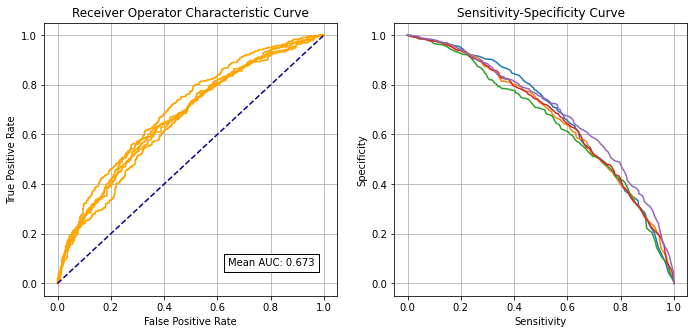

In [23]:
fig = plt.figure(figsize=(10,5))

# Plot ROC
ax1 = fig.add_subplot(121)
for i in range(5):
    ax1.plot(k_fold_fpr[i], k_fold_tpr[i], color='orange')
ax1.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('Receiver Operator Characteristic Curve')
text = f'Mean AUC: {mean_auc:.3f}'
ax1.text(0.64,0.07, text, 
         bbox=dict(facecolor='white', edgecolor='black'))
plt.grid(True)

# Plot sensitivity-specificity
ax2 = fig.add_subplot(122)
for i in range(5):
    ax2.plot(k_fold_sensitivity[i], k_fold_specificity[i])
ax2.set_xlabel('Sensitivity')
ax2.set_ylabel('Specificity')
ax2.set_title('Sensitivity-Specificity Curve')
plt.grid(True)


plt.tight_layout(pad=2)
plt.savefig('./output/decision_comparison_roc_sens_spec_key_features_model_per_hospital.jpg', dpi=300)

plt.show()

#### Identify cross-over of sensitivity and specificity

In [24]:
def get_intersect(a1, a2, b1, b2):
    """ 
    Returns the point of intersection of the lines passing through a2,a1 and b2,b1.
    a1: [x, y] a point on the first line
    a2: [x, y] another point on the first line
    b1: [x, y] a point on the second line
    b2: [x, y] another point on the second line
    """
    s = np.vstack([a1,a2,b1,b2])        # s for stacked
    h = np.hstack((s, np.ones((4, 1)))) # h for homogeneous
    l1 = np.cross(h[0], h[1])           # get first line
    l2 = np.cross(h[2], h[3])           # get second line
    x, y, z = np.cross(l1, l2)          # point of intersection
    if z == 0:                          # lines are parallel
        return (float('inf'), float('inf'))
    return (x/z, y/z)

In [25]:
intersections = []
for i in range(5):
    sens = np.array(k_fold_sensitivity[i])
    spec = np.array(k_fold_specificity[i])
    df = pd.DataFrame()
    df['sensitivity'] = sens
    df['specificity'] = spec
    df['spec greater sens'] = spec > sens

    # find last index for senitivity being greater than specificity 
    mask = df['spec greater sens'] == False
    last_id_sens_greater_spec = np.max(df[mask].index)
    locs = [last_id_sens_greater_spec, last_id_sens_greater_spec + 1]
    points = df.iloc[locs][['sensitivity', 'specificity']]

    # Get intersetction with line of x=y
    a1 = list(points.iloc[0].values)
    a2 = list(points.iloc[1].values)
    b1 = [0, 0]
    b2 = [1, 1]

    intersections.append(get_intersect(a1, a2, b1, b2)[0])

mean_intersection = np.mean(intersections)
sd_intersection = np.std(intersections)
print (f'\nMean intersection: {mean_intersection:0.4f}')
print (f'SD intersection: {sd_intersection:0.4f}')


Mean intersection: 0.6228
SD intersection: 0.0105


## Shap values

Get Shap values for each of the 5 k-fold splits. Use the training set to setup the Shap explainer, and use it to get the Shap value for each patient in the test set (will get a value for each patient for each feature). Needs to be repeated for each hosptial (a model per hospital per kfold).

Get a Shap value per feature for each k-fold by taking the average.

Look at the range of Shap values for each feature across the k-fold splits

### Get Shap values

In [26]:
shap_values_kfold = []

# initialise dictionary
shap_values_extended_kfold_hosp_dict = {}

# initialise dictionary keys
# for each dictionary, setup a key for each kfold. this key will hold a list  
# that stores a list of values (a value per instance) for each hospital
for k_fold in range(5):
    for hospital in low_thrombolysing_hospitals:
        shap_values_extended_kfold_hosp_dict[f"{hospital}_{k_fold}"]=[]

# for each kfold
for k_fold in range(5):
    hosp_shap_values_extended = []
    hosp_shap_values = []
    # for each hospital
    for hospital in low_thrombolysing_hospitals:
        # Set up explainer using typical feature values from training set
        #df_temp = pd.DataFrame(X_train_kfold_dict[f"{hospital}_{k_fold}"][0])
        explainer = shap.TreeExplainer(model_kfold_dict[f"{hospital}_{k_fold}"], 
                                       X_train_kfold_dict[f"{hospital}_{k_fold}"][0])

        # Get Shapley values along with base and feature values
#        shap_values_extended_kfold_hosp_dict[f"{k_fold}_{h}"] = (
#                                explainer(X_test_kfold_dict[f"{k_fold}"][h]))
        # Get Shapley values along with base and feature values
        shap_values_extended = explainer(X_test_kfold_dict[f"{hospital}_{k_fold}"][0])
        shap_values_extended_kfold_hosp_dict[f"{hospital}_{k_fold}"] = (
                                                        shap_values_extended)
#        hosp_shap_values_extended.append(shap_values_extended)
    
        # Shap values exist for each classification in a Tree; 1=give thrombolysis
        shap_values = shap_values_extended.values
        hosp_shap_values.append(shap_values)       
    
#    k_fold_shap_values_extended = []
    # shap values per kfold, per instance, per feature (for all hospitals)
    # shap_values_kfold[kfold][instance][feature]
    shap_values_kfold.append([x for xs in hosp_shap_values for x in xs])

    print (f'Completed {k_fold+1} of 5')

Completed 1 of 5
Completed 2 of 5
Completed 3 of 5
Completed 4 of 5
Completed 5 of 5


### Example of te code to access the Shap value for kfold 5, instance 1000, feature 2 (zero indexing)

In [27]:
shap_values_kfold[4][999][1]

0.0

### Get average Shap values for each k-fold

In [28]:
shap_values_mean_kfold = []
#features = list(X_train_kfold[0])
#features = list(X_train_kfold_dict["0"][0])
features = list(X_train_kfold_dict[f"{low_thrombolysing_hospitals[0]}_0"][0])

for k in range(5):
    shap_values = shap_values_kfold[k]
    # Get mean Shap values for each feature
    shap_values_mean = pd.DataFrame(index=features)
    shap_values_mean['mean_shap'] = np.mean(shap_values, axis=0)
    shap_values_mean['abs_mean_shap'] = np.abs(shap_values_mean)
    shap_values_mean['mean_abs_shap'] = np.mean(np.abs(shap_values), axis=0)
    shap_values_mean['rank'] = shap_values_mean['mean_abs_shap'].rank(
        ascending=False).values
    shap_values_mean.sort_index()
    shap_values_mean_kfold.append(shap_values_mean)

# Mean SHAP value for kfold 5 across all instances

In [29]:
shap_values_mean_kfold[4]

,mean_shap,abs_mean_shap,mean_abs_shap,rank
Arrival-to-scan time,-0.003834,0.003834,0.573660,3.0
Infarction,0.000000,0.000000,0.000000,7.0
Stroke severity,0.052738,0.052738,0.776978,1.0
Precise onset time,0.028140,0.028140,0.344143,5.0
Prior disability level,0.042463,0.042463,0.488508,4.0
Use of AF anticoagulents,-0.009975,0.009975,0.030464,6.0
Onset-to-arrival time,0.007860,0.007860,0.613236,2.0


### Examine consistency across top Shap values (mean |Shap|)

'Raw' Shap values from XGBoost model are log odds ratios. 

In [30]:
# Build df for k fold values
mean_abs_shap = pd.DataFrame()
for k in range(5):
    mean_abs_shap[f'{k}'] = shap_values_mean_kfold[k]['mean_abs_shap']
    
# Build df to show min, median, and max
mean_abs_shap_summary = pd.DataFrame()
mean_abs_shap_summary['min'] = mean_abs_shap.min(axis=1)
mean_abs_shap_summary['median'] = mean_abs_shap.median(axis=1) 
mean_abs_shap_summary['max'] = mean_abs_shap.max(axis=1)
mean_abs_shap_summary.sort_values('median', inplace=True, ascending=False)

In [31]:
top_10_shap = list(mean_abs_shap_summary.head(10).index)

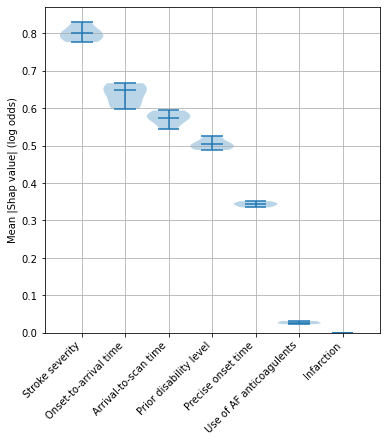

In [32]:
fig = plt.figure(figsize=(6,6))
ax1 = fig.add_subplot(111)
ax1.violinplot(mean_abs_shap.loc[top_10_shap].T,
              showmedians=True,
              widths=1)
ax1.set_ylim(0)
labels = top_10_shap
ax1.set_xticks(np.arange(1, len(labels) + 1))
ax1.set_xticklabels(labels, rotation=45, ha='right')
ax1.grid(which='both')
ax1.set_ylabel('Mean |Shap value| (log odds)')
plt.savefig('output/decision_comparison_shap_violin_key_features_model_per_hospital.jpg',
            dpi=300, bbox_inches='tight', pad_inches=0.2)
plt.show()

## Examine consitency of feature importances

In [33]:
# Build df for k fold values
importances_df = pd.DataFrame()
for k in range(5):
    importances_df[f'{k}'] = importance_kfold[k]

# Build df to show min, median, and max
importances_summary = pd.DataFrame()
importances_summary['min'] = importances_df.min(axis=1)
importances_summary['median'] = importances_df.median(axis=1) 
importances_summary['max'] = importances_df.max(axis=1)
importances_summary.sort_values('median', inplace=True, ascending=False)
importance_features_index = list(importances_summary.index)
# Add feature names back in
importances_summary['feature'] = \
    [list(X_train)[feat] for feat in importance_features_index]
importances_summary.set_index('feature', inplace=True)

In [34]:
top_10_importances = list(importances_summary.head(10).index)

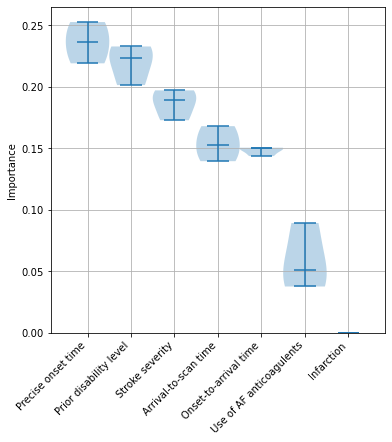

In [35]:
fig = plt.figure(figsize=(6,6))
ax1 = fig.add_subplot(111)
ax1.violinplot(importances_summary.loc[top_10_importances].T,
              showmedians=True,
              widths=1)
ax1.set_ylim(0)
labels = top_10_importances
ax1.set_xticks(np.arange(1, len(labels) + 1))
ax1.set_xticklabels(labels, rotation=45, ha='right')
ax1.grid(which='both')
ax1.set_ylabel('Importance')
plt.savefig('output/decision_comparison_importance_violin_key_features_model_per_hospital.jpg',
            dpi=300, bbox_inches='tight', pad_inches=0.2)
plt.show()

### Compare Shap and importances

In [36]:
compare_shap_importance = pd.DataFrame()
compare_shap_importance['Shap'] = mean_abs_shap_summary.head(10).index
compare_shap_importance['Importance'] = importances_summary.head(10).index
compare_shap_importance

,Shap,Importance
0,Stroke severity,Precise onset time
1,Onset-to-arrival time,Prior disability level
2,Arrival-to-scan time,Stroke severity
3,Prior disability level,Arrival-to-scan time
4,Precise onset time,Onset-to-arrival time
5,Use of AF anticoagulents,Use of AF anticoagulents
6,Infarction,Infarction


In [37]:
shap_importance = pd.DataFrame()
shap_importance['Shap'] = mean_abs_shap_summary['median']
shap_importance = shap_importance.merge(
    importances_summary['median'], left_index=True, right_index=True)
shap_importance.rename(columns={'median':'Importance'}, inplace=True)
shap_importance.sort_values('Shap', inplace=True, ascending=False)
shap_importance.head(10)

,Shap,Importance
Stroke severity,0.801244,0.189094
Onset-to-arrival time,0.648938,0.149854
Arrival-to-scan time,0.573660,0.152872
Prior disability level,0.504388,0.223300
Precise onset time,0.344143,0.236258
Use of AF anticoagulents,0.025971,0.051285
Infarction,0.000000,0.000000


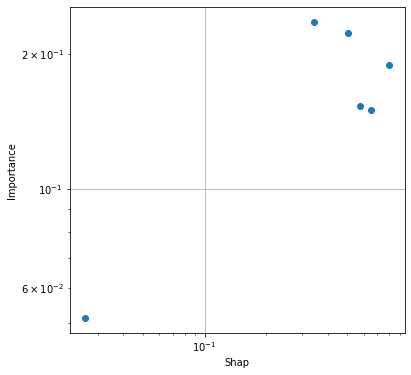

In [38]:
fig = plt.figure(figsize=(6,6))
ax1 = fig.add_subplot(111)
ax1.scatter(shap_importance['Shap'],
            shap_importance['Importance'])

ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlabel('Shap')
ax1.set_ylabel('Importance')
ax1.grid()
plt.savefig(
    'output/decision_comparison_shap_importance_correlation_key_features_model_per_hospital.jpg',
    dpi=300)
plt.show()

## Further analysis of one k-fold

Having established that Shap values have good consistency across k-fold replictaes, here we show more detail on Shap using the first k_fold replicate.

We will look into detailed Shap values for the first train/test split.

### First get the necesary data
And in the right format - some are ready to use, others are split across multiple keys in a dictionary.

In [39]:
# Get required values from first k fold
k_fold = 0

shap_values = np.array(shap_values_kfold[k_fold])
importances = importance_kfold[k_fold]
y_pred = predicted_kfold[k_fold]
y_prob = predicted_proba_kfold[k_fold]

# Create a dataframe for kfold 0 with all hospital data (train and test sets)
X_train = pd.DataFrame(columns=features)
X_test = pd.DataFrame(columns=features)
y_train = pd.DataFrame(columns=features)
y_test = pd.DataFrame(columns=features)
for hospital in low_thrombolysing_hospitals:
    X_train = pd.concat([X_train, X_train_kfold_dict[f"{hospital}_{k_fold}"][0]])
    X_test = pd.concat([X_test, X_test_kfold_dict[f"{hospital}_{k_fold}"][0]])
    y_train = pd.concat([y_train, y_train_kfold_dict[f"{hospital}_{k_fold}"][0]])
    y_test = pd.concat([y_test, y_test_kfold_dict[f"{hospital}_{k_fold}"][0]])
    


Create a shap_values_extended for the first k fold

This can be used as if it is the output from explainer for all the instances (from all the hospitals) in kfold0.

Join up all the base values, and shap values and data for each hospital, and put in a single shap_values_extended for the kfold.

sve_kfold stands for "shap values extended, for kfold 0". It will contain the .values, .base_values and .data for all of the hospitals (that are currently held in individual dictionaries.

In [40]:
k_fold = 0

# Take a deep copy of the shap_values_extended for the first hospital
key = f"{low_thrombolysing_hospitals[0]}_{k_fold}"
sve_kfold0 = copy.deepcopy(shap_values_extended_kfold_hosp_dict[key])

# Create three numpy arrays to store the values for all the hospitals.
# Here store the values (for the three methods (KP are they called methods?)) for the first hospital
values_array = sve_kfold0.values
base_values_array = sve_kfold0.base_values
data_array = sve_kfold0.data

# Go through the remaining hospitals, adding their values to the numpy arrays 
for hospital in low_thrombolysing_hospitals[1:]:
    # Extract values from dictionary
    key = f"{hospital}_{k_fold}"
    sve_kfold0 = copy.deepcopy(shap_values_extended_kfold_hosp_dict[key])
    # Save values in numpy arrays
    values_array = np.concatenate([values_array, sve_kfold0.values])
    base_values_array = np.concatenate([base_values_array, sve_kfold0.base_values])
    data_array = np.concatenate([data_array, sve_kfold0.data])

# Overwrite with the full values from all hospitals. 
# This can be used as if it is the output from explainer for all the instances
# (from all the hospitals) in kfold0 
sve_kfold0.values = values_array
sve_kfold0.base_values = base_values_array
sve_kfold0.data = data_array

### Beeswarm plot

A Beeswarm plot shows all points. The feature value for each point is shown by the colour, and its position indicates the Shap value for that instance.

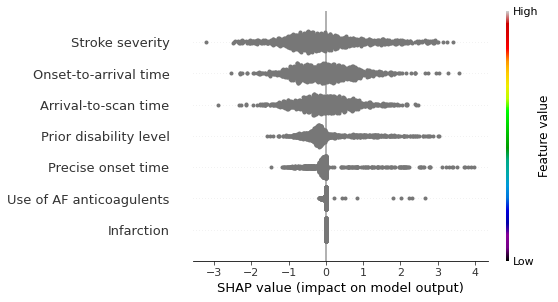

In [41]:
fig = plt.figure(figsize=(6,6))

shap.summary_plot(shap_values=shap_values, 
                  features=X_test,
                  feature_names=features,
                  max_display=8,
                  cmap=plt.get_cmap('nipy_spectral'), show=False)
plt.savefig('output/xgb_decision_comparison_beeswarm_key_features_model_per_hospital.jpg', 
            dpi=300, bbox_inches='tight', pad_inches=0.2)
plt.show()

# Look into this
Why isn't the beeswarm colouring the graph? X_test contains the data values in the same format as expected. 


In [42]:
X_test

,Arrival-to-scan time,Infarction,Stroke severity,Precise onset time,Prior disability level,Use of AF anticoagulents,Onset-to-arrival time
1250,11.0,1,9.0,1,0,0,117.0
2772,28.0,1,19.0,1,2,0,70.0
3919,79.0,1,14.0,1,0,0,108.0
9184,23.0,1,18.0,1,2,0,46.0
13524,51.0,1,20.0,1,1,0,140.0
...,...,...,...,...,...,...,...
60069,137.0,1,9.0,1,0,0,68.0
61821,4.0,1,12.0,1,4,0,110.0
63124,3.0,1,11.0,1,3,0,110.0
77702,18.0,1,20.0,1,0,0,83.0


### Plot Waterfall and decision plot plots for instances with low or high probability of making a different decision

Waterfall plot and decision plots are alternative ways of plotting the influence of features for individual cases.

In [43]:
# Get the location of an example of high probablility of thrombolysis
location_high_probability = np.where(y_prob == np.max(y_prob))[0][0]

In [44]:
sve_kfold0[location_high_probability]

.values =
array([ 1.44954737,  0.        ,  2.4951422 , -0.08350656, -0.11216167,
        0.        ,  1.68721694])

.base_values =
-0.377197760956933

.data =
array([ 33.,   1.,   4.,   1.,   0.,   0., 128.])

An example with high probability of a low thrombolysing unit deciding not to give thrombolysis to a patient when the benchmark hospitals would.

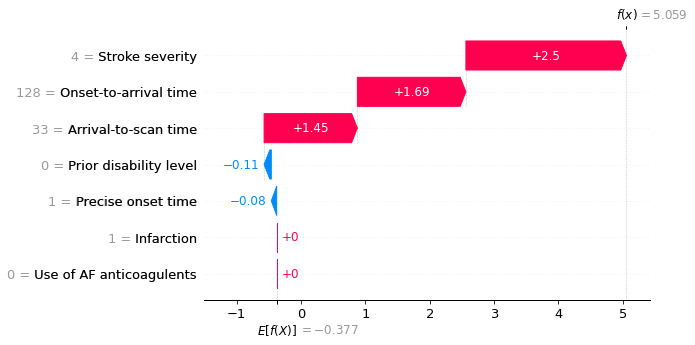

In [45]:
fig = shap.plots.waterfall(sve_kfold0[location_high_probability],
                           show=False, max_display=8)
plt.savefig('output/xgb_decision_comparison_waterfall_high_key_features_model_per_hospital.jpg',
            dpi=300, bbox_inches='tight', pad_inches=0.2)
plt.show()

### Show the relationship between feature value and Shap value for influential features.

#### Show Shap as a scatter plot

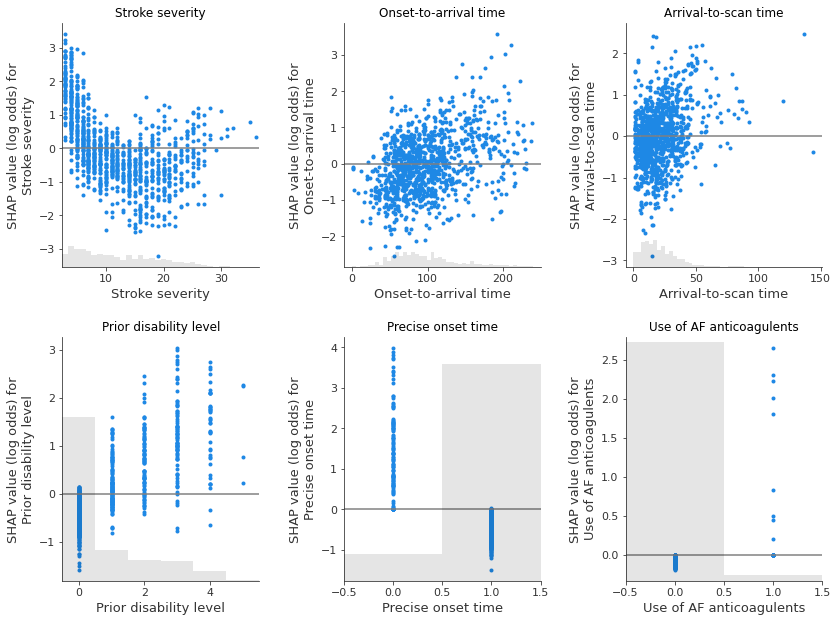

In [46]:
feat_to_show = top_10_shap[0:6]

fig = plt.figure(figsize=(12,9))
for n, feat in enumerate(feat_to_show):    
    ax = fig.add_subplot(2,3,n+1)
    shap.plots.scatter(sve_kfold0[:, feat], x_jitter=0, ax=ax, 
                       show=False)
    
    # Add line at Shap = 0
    feature_values = sve_kfold0[:, feat].data
    ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [0,0], c='0.5')    
    
    ax.set_ylabel(f'SHAP value (log odds) for\n{feat}')
    ax.set_title(feat)
    
plt.tight_layout(pad=2)
    
fig.savefig('output/xgb_prediciting_difference_shap_scatter_model_per_hospital.jpg', dpi=300,
    bbox_inches='tight', pad_inches=0.2)

#### Show Shap as a violin plot

In [47]:
def set_ax(ax, category_list, feat, rotation=0):
    '''
    ax [matplotlib axis object] = matplotlib axis object
    category_list [list] = used for the xtick labels (the grouping of the data)
    rotation [integer] = xtick label rotation
    feat [string] = used in the axis label, the feature that is being plotted
    
    resource: 
    https://matplotlib.org/3.1.0/gallery/statistics/customized_violin.html
    '''
    # Set the axes ranges and axes labels
    ax.get_xaxis().set_tick_params(direction='out')
    ax.xaxis.set_ticks_position('bottom')
    ax.set_xticks(np.arange(1, len(category_list) + 1))
    ax.set_xticklabels(category_list, rotation=rotation, fontsize=10)
    ax.set_xlim(0.25, len(category_list) + 0.75)
    ax.set_ylabel(f'Shap values for {feat}', fontsize=12)
    ax.set_xlabel(f'Feature values for {feat}', fontsize=12)
    return(ax)

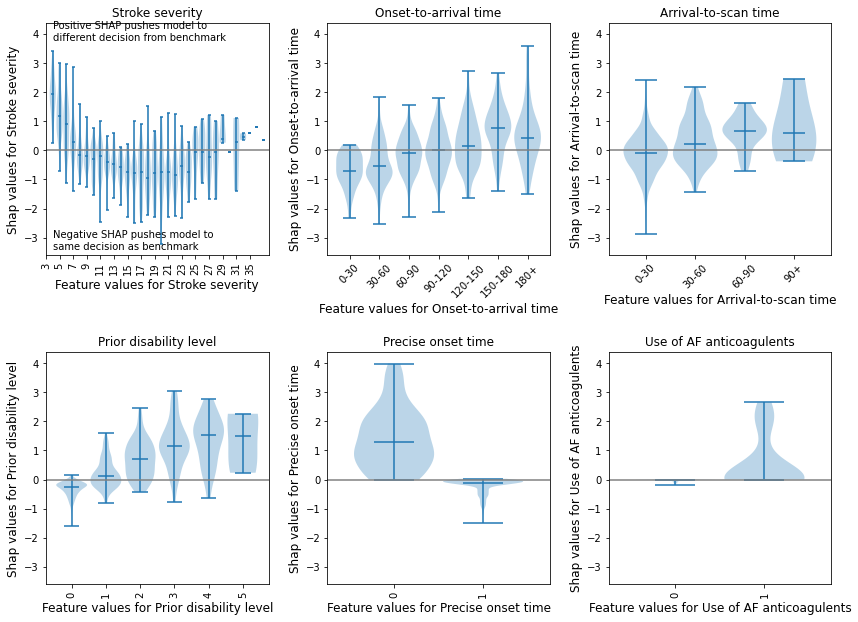

In [48]:
feat_to_show = top_10_shap[0:6]

# Get shap min and max (to put all charts on same scale)
shap_min = sve_kfold0.values.min()
shap_max = sve_kfold0.values.max()

fig = plt.figure(figsize=(12,9))
# for each feature, prepare the data for the violin plot.
# data either already in categories, or if there's more than 50 unique values
# for a feature then assume it needs to be binned, and a violin for each bin
for n, feat in enumerate(feat_to_show):    
    feature_data = sve_kfold0[:, feat].data
    feature_shap = sve_kfold0[:, feat].values

    # if feature has more that 50 unique values, then assume it needs to be 
    # binned (other assume they are unique categories)
    if np.unique(feature_data).shape[0] > 50:
        # bin the data, create a violin per bin
        
        # settings for the plot
        rotation = 45
        step = 30
        n_bins = min(16, np.int((feature_data.max())/step))
        
        # create list of bin values
        bin_list = [(i*step) for i in range(n_bins)]
        bin_list.append(feature_data.max())

        # create list of bins (the unique categories)
        category_list =  [f'{i*step}-{(i+1)*step}' for i in range(n_bins-1)]
        category_list.append(f'{(n_bins-1)*step}+')

        # bin the feature data
        feature_data = pd.cut(feature_data, bin_list, labels=category_list)

    else:
        # create a violin per unique value
        
        # settings for the plot
        rotation = 90
        
        # create list of unique categories in the feature data
        category_list = np.unique(feature_data)
        category_list = [int(i) for i in category_list]

    # create a list, each entry contains the corresponsing Shap value for that 
    # category (or bin). A violin will represent each list.    
    shap_per_category = []
    for category in category_list:
        mask = feature_data == category
        shap_per_category.append(feature_shap[mask])

    # create violin plot
    ax = fig.add_subplot(2, 3 ,n+1)
    ax.violinplot(shap_per_category, showmedians=True, widths=0.9)    
    
    # Add line at Shap = 0
    feature_values = sve_kfold0[:, feat].data
    ax.plot([0, len(feature_values)], [0,0],c='0.5')   

    # customise the axes
    ax = set_ax(ax, category_list, feat, rotation=rotation)
    plt.subplots_adjust(bottom=0.15, wspace=0.05)
    
    # Adjust stroke severity tickmarks
    if feat == 'Stroke severity':
        ax.set_xticks(np.arange(0, len(category_list), 2))
        ax.set_xticklabels(category_list[0::2])
            
    # Add title
    ax.set_title(feat) 
    
    # Set ylims
    ax.set_ylim(shap_min - 0.4, shap_max + 0.4)
    
    # Add direction of SHAP on first chart
    if n == 0:
        txt = "Negative SHAP pushes model to\nsame decision as benchmark"
        ax.text(1, shap_min - 0.2, txt)
        txt = "Positive SHAP pushes model to\ndifferent decision from benchmark"
        ax.text(1, shap_max - 0.2, txt)
        
        
    
plt.tight_layout(pad=2)
    
fig.savefig(
    f'output/xgb_predicting_difference_shap_violin_model_per_hospital.jpg', dpi=300,
     bbox_inches='tight', pad_inches=0.2)

## Repeat the waterfall plots, this time using probability values

Though Shap values for XGBoost most accurately describe the effect on log odds ratio of classification, it may be easier for people to understand influence of features using probabilities. Here we plot waterfall plots using probabilities.

A disadvantage of this method is that it distorts the influence of features someone - those features pushing the probability down from a low level to an even lower level get 'squashed' in apparent importance. This distortion is avoided when plotting log odds ratio, but at the cost of using an output that is poorly understandable by many.

svep_kfold0 stands for "shap values extended in probability units, for kfold0"

In [49]:
# Create a Tree Explainer whith units in probability (instead of log odds).

# Start with the first hospital (to initialise the numpy arrays
hospital = low_thrombolysing_hospitals[0]
explainer_prob = shap.TreeExplainer(model_kfold_dict[f"{hospital}_{k_fold}"], 
                               X_train_kfold_dict[f"{hospital}_{k_fold}"][0],
                               model_output='probability')

# Get Shapley values (along with base and feature values)
svep_kfold0 = explainer_prob(X_test_kfold_dict[f"{hospital}_{k_fold}"][0])

values_array = svep_kfold0.values
base_values_array = svep_kfold0.base_values
data_array = svep_kfold0.data

# Then repeat for the other hospitals
for hospital in low_thrombolysing_hospitals[1:]:
    # Set up explainer using typical feature values from training set
    explainer_prob = shap.TreeExplainer(model_kfold_dict[f"{hospital}_{k_fold}"], 
                                   X_train_kfold_dict[f"{hospital}_{k_fold}"][0],
                                   model_output='probability')

    # Get Shapley values along with base and feature values
    svep_kfold0 = explainer_prob(X_test_kfold_dict[f"{hospital}_{k_fold}"][0])

    # Add values to the numpy array
    values_array = np.concatenate([values_array, svep_kfold0.values])
    base_values_array = np.concatenate([base_values_array, svep_kfold0.base_values])
    data_array = np.concatenate([data_array, svep_kfold0.data])

# Store values back in the main array
svep_kfold0.values = values_array
svep_kfold0.base_values = base_values_array
svep_kfold0.data = data_array

An example with high probability of a low thrombolysing unit making deciding not to give thrombolysis to a patient when the benchmark hospitals would.

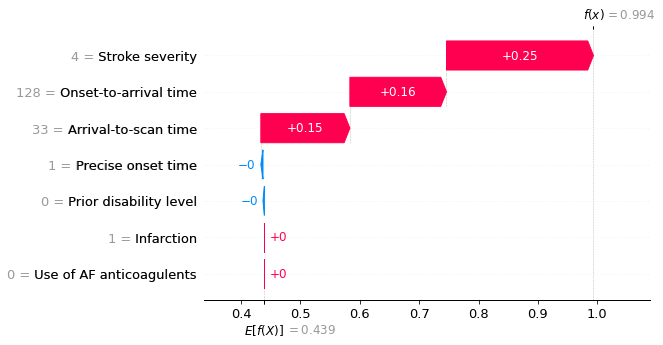

In [50]:
fig = shap.plots.waterfall(svep_kfold0[location_high_probability],
                           show=False, max_display=8)
plt.savefig(
    'output/xgb_decision_comparison_waterfall_high_probability_key_features_model_per_hospital.jpg', 
    dpi=300, bbox_inches='tight', pad_inches=0.2)
plt.show()

## Observations

* We can predict those that will *not* receive thrombolysis at a local unit, out of those who will be thrombolysed by the majority of the benchmark hospitals, with 67% accuracy (AUC 0.733).

* The five most important distinguishing features are:
    * Stroke severity
    * Prior disability level
    * Precise onset time
    * Arrival-to-scan time
    * Onset-to-arrival time